<a href="https://colab.research.google.com/github/gibsonx/tf_skeleton/blob/master/hm_regression_prelim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import os

import tensorflow.keras.backend as K
import keras.utils

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Activation, Add, Conv2D, Conv2DTranspose, concatenate, Cropping2D, MaxPooling2D, Reshape, UpSampling2D
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.optimizers import SGD, RMSprop, Adam
from keras.regularizers import l2

from pycocotools.coco import COCO
import numpy as np
import os.path
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, json, cv2, numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.bool = np.bool_
import matplotlib.pyplot as plt
import keras

import tensorflow as tf

from keras.models import Sequential,Model

from keras.layers import (
    Flatten,
    Dense,
    Dropout,
    Conv2D,
    LeakyReLU,
    BatchNormalization,
    MaxPool2D,
    GlobalAveragePooling2D,
)
from imgaug import augmenters as iaa
import imgaug as ia
import imageio
from keras.applications import ResNet50
from keras.applications.densenet import DenseNet121,DenseNet169,DenseNet201
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# X-Ray Dataset loader

In [3]:
class DataframeMaker():

  def __init__(self,img_path,annotations_file, img_height, img_width, cut_width):
      self.img_path = img_path
      self.coco = COCO(annotations_file)
      self.imgIds = self.coco.getImgIds()
      self.dataframe = None
      self.__coco_build__()
      self.img_height = img_height
      self.img_width = img_width
      self.cut_width = cut_width
      if self.img_width and self.img_height:
          self.resize_dataset()
          print ("image size has been set to %d x %d" % (self.img_height, self.img_width))
      else:
          print ("image keeps as original size")

  def __coco_build__(self):
      """
      read annotation and build dataframe
      :return:
      """
      kps_metrix = []

      for id in self.imgIds:

        # load a image
        img = self.coco.loadImgs(id)[0]
        imgPath = img['file_name']

        ann=self.coco.loadAnns(self.coco.getAnnIds(imgIds=img['id']))

        keypoints_original = [[list(a) for a in zip(*[iter(ann[0]['keypoints'])]*3)]]

        kps_row = []
        for kp in keypoints_original:
            for el in kp:
                kps_row.extend(el[0:2])
        kps_row.append(imgPath)

        kps_metrix.append(kps_row)

      df = pd.DataFrame(kps_metrix)

      self.dataframe = df

  def resize_dataset(self):
    """
    :param img_height:
    :param img_width:
    :return:
    """
    ts_kps_metrix = []
    ts_image_list = []

    for index, row in self.dataframe.iterrows():


      image = row[-1:].item()
      fullImgPath = os.path.join(self.img_path,image)
      open_cv_image = np.array(Image.open(fullImgPath).convert('RGB'))
      # print("shpae:",open_cv_image.shape)

      annotations = row[:32]
      converted_keypoints = [list(a) for a in zip(*[iter(annotations)]*2)]

      kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]
      kpsoi = KeypointsOnImage(kps, shape=open_cv_image.shape)

      ia.seed(1)

      seq = iaa.Sequential([
          iaa.Crop(px=(32, 32, 32, 32)),
          iaa.Resize({"height": self.img_height , "width": self.img_width}),
          iaa.CropToFixedSize(height=self.cut_width, width=self.cut_width, position="center-top")
      ])

      image_aug, kpsoi_aug = seq(image=open_cv_image, keypoints=kpsoi)

      ts_kps_row = []

      for i in range(len(kpsoi_aug.keypoints)):
          after = kpsoi_aug.keypoints[i]
          ts_kps_row.extend([after.x,after.y])

      ts_kps_metrix.append(ts_kps_row)
      ts_image_list.append(image_aug)

    df = pd.DataFrame(ts_kps_metrix)

    df['image'] = ts_image_list

    self.dataframe = df

In [4]:
height = 500
width = 280
cut_width = 224
num_kps = 16

data_dir = "/content/drive/MyDrive/Dataset/facial-keypoints-detection/"

train_img_dir="/content/drive/MyDrive/Dataset/aspine202030604/images"
train_annotations_file="/content/drive/MyDrive/Dataset/aspine202030604/annotations/person_keypoints_Train.json"

val_img_dir="/content/drive/MyDrive/Dataset/aspine20230930/image_val"
val_annotations_file="/content/drive/MyDrive/Dataset/aspine20230930/annotations/person_keypoints_Validation.json"


val_df = DataframeMaker(val_img_dir,val_annotations_file,height,width,cut_width)
train_df = DataframeMaker(train_img_dir,train_annotations_file,height,width,cut_width)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
image size has been set to 500 x 280
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
image size has been set to 500 x 280


# X-Ray DataGenerator

In [5]:
class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, dataframe, batch_size, arguement = False, **kwargs):
      self.df = dataframe
      self.batch_size = batch_size
      self.argument = arguement
      self.workers = kwargs.pop('workers', 4)
      self.use_multiprocessing = kwargs.pop('use_multiprocessing', False)
      self.max_queue_size = kwargs.pop('max_queue_size', 10)

  def __len__(self):
      return math.ceil(len(self.df) / self.batch_size)

  # check if transformed point is located within image boundaries
  def _checkBoundaries(self, p):

      # x dimension
      if p[0] < 0:
          px = 0
      elif p[0] > self.target_size[0]:
          px = self.target_size[0]
      else:
          px = p[0]

      # y dimension
      if p[1] < 0:
          py = 0
      elif p[1] > self.target_size[1]:
          py = self.target_size[1]
      else:
          py = p[1]

      return (int(px), int(py))

  # apply gaussian kernel to image
  def _gaussian(self, xL, yL, sigma, H, W):

      channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
      channel = np.array(channel, dtype=np.float32)
      channel = np.reshape(channel, newshape=(H, W))

      return channel

  # convert original image to heatmap
  def _convertToHM(self, img, keypoints, sigma=5):

      H = img.shape[0]
      W = img.shape[1]
      nKeypoints = len(keypoints)

      img_hm = np.zeros(shape=(H, W, nKeypoints // 2), dtype=np.float32)

      for i in range(0, nKeypoints // 2):
          x = keypoints[i * 2]
          y = keypoints[1 + 2 * i]

          channel_hm = self._gaussian(x, y, sigma, H, W)

          img_hm[:, :, i] = channel_hm

      img_hm = np.reshape(img_hm, newshape=(img_hm.shape[0]*img_hm.shape[1]*nKeypoints // 2, 1))

      return img_hm

  def __getitem__(self, idx):
      low = idx * self.batch_size
      # Cap upper bound at array length; the last batch may be smaller
      # if the total number of items is not a multiple of batch size.
      high = min(low + self.batch_size, len(self.df))
      # images = self.df.loc[low:high,'image']
      # annotations = self.df.loc[low:high,:31]
      current_batch = self.df.iloc[low:high]

      x = [] # images
      y = [] # masks
      z = [] # keypoinsts

      for index, row in current_batch.iterrows():

        img = row['image']
        # img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        img = np.float32(img) / 255

        keypoints = row[:32]
        img_hm = self._convertToHM(img, keypoints)

        x.append(img)
        y.append(img_hm)
        z.append(keypoints)

      if self.argument:
         return self.data_arguement(x, z)
      else:
         return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

  def on_epoch_end(self):
      print("shuffle")
      self.df = self.df.sample(frac=1, random_state=41).reset_index(drop=True)

  def data_arguement(self, images, annotations):

      ia.seed(3)
      seq = iaa.Sequential([
            iaa.Sometimes(
              0.5,
              iaa.SomeOf((1, 3), [
              iaa.Affine(
                  rotate=(-3,3)
                  ),
              iaa.LinearContrast((0.4, 1.2)),
              # iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
              ])
            )
          ])

      images_aug, points_aug = seq(images=images, keypoints=self.kpslist_to_tuple(annotations))
      kps_list = self.kpstuple_to_list(points_aug)

      x = [] # images
      y = [] # masks

      for i in range(len(images_aug)):
        img_hm = self._convertToHM(images_aug[i], kps_list[i])
        x.append(images_aug[i])
        y.append(img_hm)

      return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

  def kpslist_to_tuple(self,annotations):
      kpstuple = []

      for row in annotations:
        converted_keypoints = [list(a) for a in zip(*[iter(row)]*2)]
        kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]
        kpstuple.append(kps)

      return kpstuple

  def kpstuple_to_list(self,kps_tuple):
      kpslist = []

      for kpsoi in kps_tuple:
          ts_kps_row = []
          for i in range(len(kpsoi)):
              # print(kpsoi_aug[i].is_out_of_image(image=images_aug[i]))
              ts_kps_row.extend([kpsoi[i].x,kpsoi[i].y])
          kpslist.append(ts_kps_row)

      return kpslist

## Load Training Data

In [6]:
batch_size=16

val_gen = DataGenerator(val_df.dataframe,batch_size,False)
train_gen = DataGenerator(train_df.dataframe,batch_size,False)

In [7]:
train_imgs, train_masks = train_gen[0]
val_imgs, val_masks = val_gen[0]

In [8]:
train_imgs[0].shape

(224, 224, 3)

# show xray makes

In [9]:
def show_xray_masks(height, width, num_kps, batch_imgs, batch_gt_masks, nrows, ncols, include_preds= False, predictions=None):

    if not include_preds:
        nrows -= 1

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

    r = -1

    for c in range(ncols):

        # original image
        img = batch_imgs[c]
        # img = np.reshape(img, newshape=(height, width))
        # img = np.stack([img,img,img], axis=-1)

        # ground-truth mask
        gt_mask = batch_gt_masks[c]
        gt_mask = np.reshape(gt_mask, newshape=(height, width, num_kps))
        gt_mask = np.sum(gt_mask, axis=-1)

        axes[0, c].imshow(img)
        axes[1, c].imshow(gt_mask)

        # prediction mask
        if include_preds:
            pred_mask = predictions[c]
            pred_mask = np.reshape(pred_mask, newshape=(height, width, num_kps))
            pred_mask = np.sum(pred_mask, axis=-1)
            axes[2, c].imshow(pred_mask)

    plt.show()

#Visualize Train Dataset

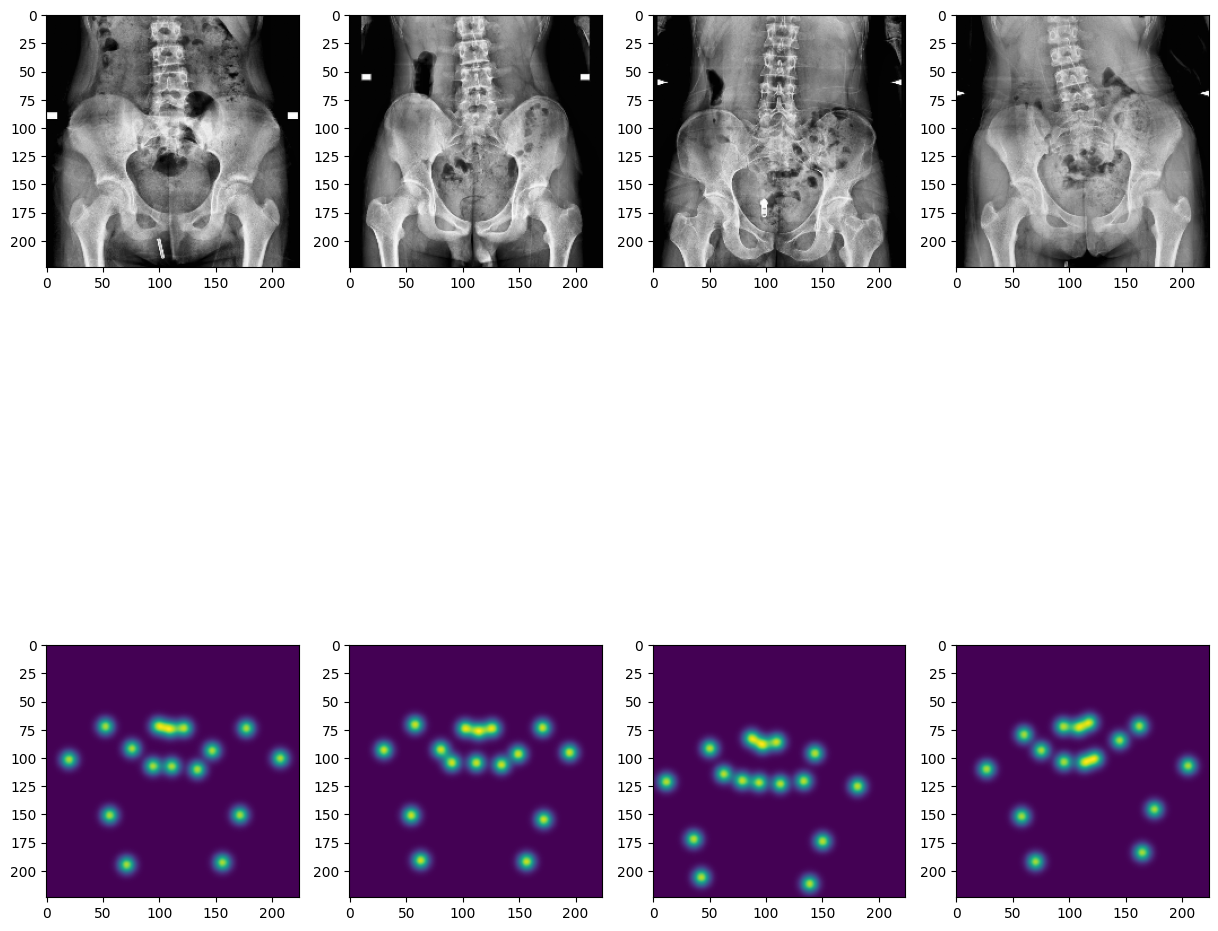

In [10]:
show_xray_masks(cut_width, cut_width, num_kps, train_imgs[0:4], train_masks[0:4], nrows=3, ncols=4)

# Visualize Validation Dataset

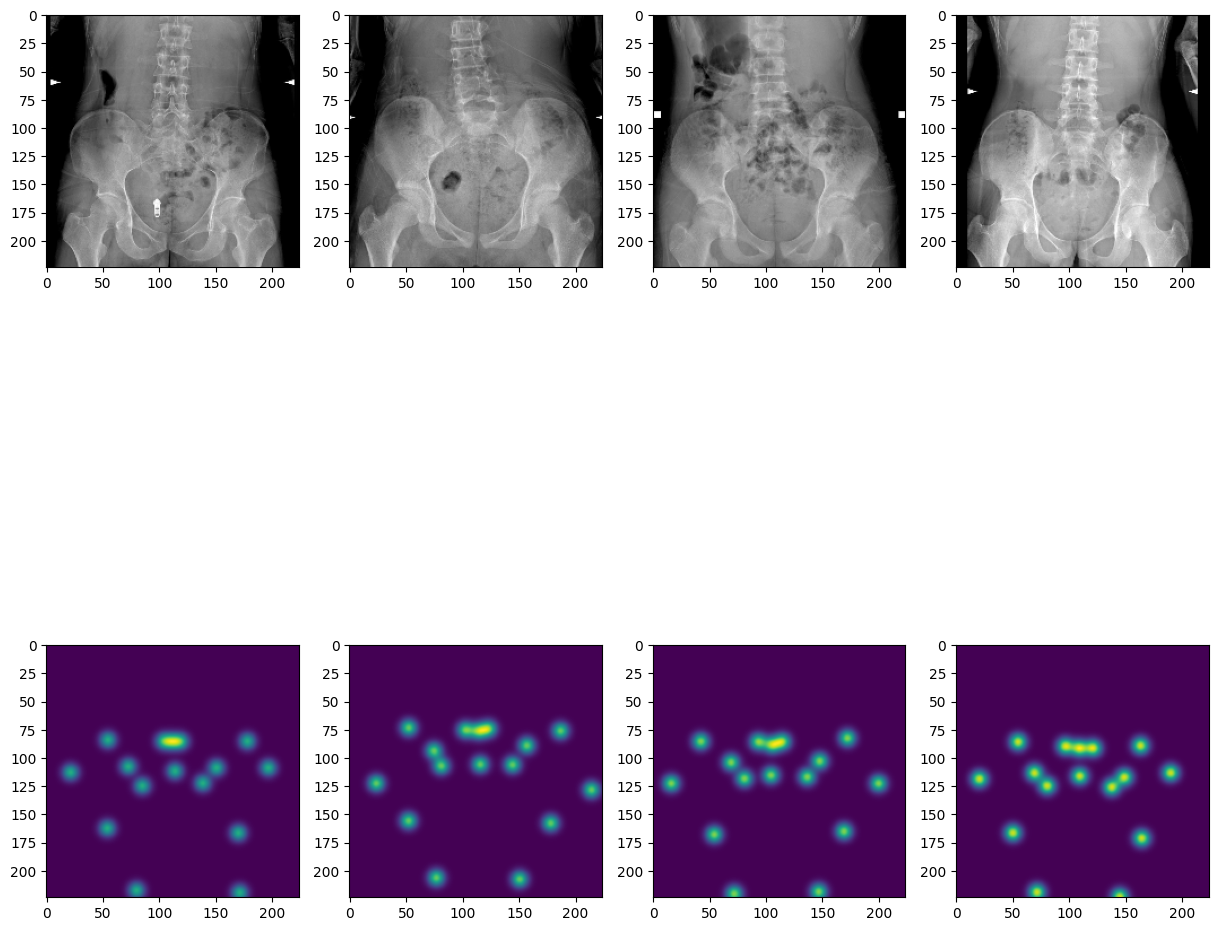

In [11]:
show_xray_masks(cut_width, cut_width, num_kps, val_imgs[0:4], val_masks[0:4], nrows=3, ncols=4)

### UNet

In [12]:
def UNET(input_shape):
    def downsample_block(x, block_num, n_filters, pooling_on=True):

        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv1")(x)
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv2")(x)
        skip = x

        if pooling_on is True:
            x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="Block" + str(block_num) + "_Pool1")(x)

        return x, skip

    def upsample_block(x, skip, block_num, n_filters):

        # if x.shape[1] * 2 != skip.shape[1]:
            # dw = int(skip.shape[1] - (x.shape[1] * 2)) // 2
            # skip = Cropping2D(cropping=((dw, dw), (dw, dw)), name="Block" + str(block_num) + "_Crop1")(skip)

        x = Conv2DTranspose(n_filters, kernel_size=(2, 2), strides=2, padding='valid', activation='relu',
                            name="Block" + str(block_num) + "_ConvT1")(x)
        x = concatenate([x, skip], axis=-1, name="Block" + str(block_num) + "_Concat1")
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv1")(x)
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv2")(x)

        return x

    input = Input(input_shape, name="Input")

    # downsampling
    x, skip1 = downsample_block(input, 1, 64)
    x, skip2 = downsample_block(x, 2, 128)
    x, skip3 = downsample_block(x, 3, 256)
    x, skip4 = downsample_block(x, 4, 512)
    x, _ = downsample_block(x, 5, 1024, pooling_on=False)


    # upsampling
    x = upsample_block(x, skip4, 6, 512)
    x = upsample_block(x, skip3, 7, 256)
    x = upsample_block(x, skip2, 8, 128)
    x = upsample_block(x, skip1, 9, 64)

    output = Conv2D(16, kernel_size=(1, 1), strides=1, padding='valid', activation='linear', name="output")(x)
    output = Reshape(target_shape=(input_shape[0]*input_shape[1]*16,1))(output)

    model = Model(inputs=input, outputs=output, name="Output")

    return model


model = UNET(input_shape=(cut_width, cut_width, 3))
print(model.summary())

Model: "Output"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)        │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block1_Conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ Input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block1_Conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ Block1_Conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block1_Pool1              │ (None, 112, 112, 64)   │              0 │ Block1_Conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block2_Conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ Block1_Pool1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block2_Conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ Block2_Conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block2_Pool1              │ (None, 56, 56, 128)    │              0 │ Block2_Conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block3_Conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ Block2_Pool1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block3_Conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ Block3_Conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block3_Pool1              │ (None, 28, 28, 256)    │              0 │ Block3_Conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block4_Conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ Block3_Pool1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block4_Conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ Block4_Conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block4_Pool1              │ (None, 14, 14, 512)    │              0 │ Block4_Conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block5_Conv1 (Conv2D)     │ (None, 14, 14, 1024)   │      4,719,616 │ Block4_Pool1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block5_Conv2 (Conv2D)     │ (None, 14, 14, 1024)   │      9,438,208 │ Block5_Conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block6_ConvT1             │ (None, 28, 28, 512)    │      2,097,664 │ Block5_Conv2[0][0]     │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Block6_Concat1            │ (None, 28, 28, 1024)   │              0 │ Block6_ConvT1[0][0],   │
│ (Concatenate)        

 Total params: 31,032,720 (118.38 MB)

 Trainable params: 31,032,720 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

None


## Training

In [13]:
def jaccard(ytrue, ypred, smooth=1e-5):

    intersection = K.sum(K.abs(ytrue*ypred), axis=-1)
    union = K.sum(K.abs(ytrue)+K.abs(ypred), axis=-1)
    jac = (intersection + smooth) / (union-intersection+smooth)

    return K.mean(jac)


In [14]:
def mean_squared_error(y_true, y_pred):
    channel_loss = K.sum(K.square(y_pred - y_true), axis=-1)
    total_loss = K.mean(channel_loss, axis=-1)
    return total_loss

In [17]:
def create_callbacks(wts_fn, lr_decay = 0.25, patience=30, enable_save_wts = True):

    cbks = []

    #earning rate
    # lr_schedule = ReduceLROnPlateau(monitor='val_loss',
    #                                 factor=lr_decay,
    #                                 patience=patience,
    #                                 min_lr=1e-6,
    #                                 verbose=1)
    # cbks.append(lr_schedule)

    # Early stopping
    early_stopper = EarlyStopping(monitor='val_loss', patience=patience)
    cbks.append(early_stopper)

    # model checkpoint
    if enable_save_wts is True:
        model_chpt = ModelCheckpoint(filepath=wts_fn,
                        monitor='val_loss',
                        verbose=1,
                        save_weights_only=True,
                        save_best_only=True,
                        save_freq=patience)

        cbks.append(model_chpt)

    return cbks

### Train Models

In [ ]:
n_epochs=200
lr=1e-5
load_saved_wts=True

wts_fn = os.path.join(data_dir + "unet1.weights.h5")

if load_saved_wts is True:
    model.load_weights(wts_fn)

# optim = RMSprop(learning_rate=lr)
optim = Adam(learning_rate=lr)
cbks = create_callbacks(wts_fn)
model.compile(loss="mean_squared_error", optimizer=optim, metrics=['accuracy',jaccard])
history = model.fit(train_gen,
      validation_data=val_gen,
      batch_size=16,
      epochs=n_epochs,
      callbacks=cbks)

Epoch 1/200
 3/12 ━━━━━━━━━━━━━━━━━━━━ 5s 643ms/step - accuracy: 0.7500 - jaccard: 0.0882 - loss: 1.1393e-04shuffle
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7496 - jaccard: 0.0882 - loss: 1.1631e-04shuffle
shuffle
shuffle
12/12 ━━━━━━━━━━━━━━━━━━━━ 307s 13s/step - accuracy: 0.7496 - jaccard: 0.0882 - loss: 1.1661e-04 - val_accuracy: 0.7538 - val_jaccard: 0.0858 - val_loss: 0.0010
Epoch 2/200
 2/12 ━━━━━━━━━━━━━━━━━━━━ 4:44 28s/step - accuracy: 0.7492 - jaccard: 0.0845 - loss: 1.3295e-04  shuffle
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7489 - jaccard: 0.0821 - loss: 1.1200e-04shuffle
shuffle
shuffle
12/12 ━━━━━━━━━━━━━━━━━━━━ 195s 9s/step - accuracy: 0.7489 - jaccard: 0.0819 - loss: 1.1184e-04 - val_accuracy: 0.7538 - val_jaccard: 0.0749 - val_loss: 0.0010
Epoch 3/200


## Evaluation on Validation Set

In [ ]:
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy (or jaccard index in this case)
plt.subplot(1, 2, 2)
plt.plot(history.history['jaccard'], label='Train Jaccard')
plt.plot(history.history['val_jaccard'], label='Val Jaccard')
plt.title('Model Jaccard')
plt.xlabel('Epoch')
plt.ylabel('Jaccard')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def maskToKeypoints(mask):
    kp = np.unravel_index(np.argmax(mask, axis=None), shape=(cut_width, cut_width))
    return kp[1], kp[0]


def calcKeypoints(model, gen):
    kps_gt = []
    kps_preds = []
    nbatches = len(gen)

    for i in range(nbatches):
        # print("\nBatch {}".format(i))
        imgs, batch_gt = gen[i]
        batch_preds = model.predict(imgs)

        n_imgs = imgs.shape[0]
        for j in range(n_imgs):
          mask_gt = batch_gt[j]
          mask_gt = np.reshape(mask_gt, newshape=(cut_width, cut_width, num_kps))
          mask_pred = batch_preds[j]
          mask_pred = np.reshape(mask_pred, newshape=(cut_width, cut_width, num_kps))
          nchannels = mask_gt.shape[-1]

          gt_list = []
          pred_list = []

          for k in range(nchannels):
              xgt, ygt = maskToKeypoints(mask_gt[:, :, k])
              xpred, ypred = maskToKeypoints(mask_pred[:, :, k])

              gt_list.append(xgt)
              gt_list.append(ygt)

              pred_list.append(xpred)
              pred_list.append(ypred)

          kps_gt.append(gt_list)
          kps_preds.append(pred_list)



    return np.array(kps_gt, dtype=np.float32), np.array(kps_preds, dtype=np.float32)


def calcRMSError(kps_gt, kps_preds):

    N = kps_gt.shape[0] * (kps_gt.shape[-1] // 2)
    error = np.sqrt(np.sum((kps_gt-kps_preds)**2)/N)

    return error

### Visualize Keypoints

In [ ]:
def show_keypoints(batch_imgs, batch_labels, nrows, ncols, predictions=None):

    def draw_keypoints(img, keypoints, col):
        # print("\n{}".format(len(keypoints)))
        for i in range(0, len(keypoints)-1, 2):
            # print(i)
            kpx = int(keypoints[i])
            kpy = int(keypoints[i+1])
            img = cv.circle(img, center=(kpx,kpy), radius=2, color=col, thickness=2)

        return img

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

    r = -1

    for i in range(len(batch_imgs)):

        img = batch_imgs[i]
        # img = np.reshape(img, newshape=(cut_width, cut_width))
        # img = np.stack([img,img,img], axis=-1)

        c = i % ncols

        if i % ncols == 0:
            r += 1

        # draw ground-truth keypoints on image
        if batch_labels is not None:
            img = draw_keypoints(img, batch_labels[i], col=(0,0,255))

        # draw predicted keypoints on image
        if predictions is not None:
            img = draw_keypoints(img, predictions[i], col=(255,0,0))

        axes[r, c].imshow(img)

    plt.show()

### Visualize All Masks

In [ ]:
def showAllMasks(width,img_mask, nrows=4, ncols=5):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    r = -1

    for i in range(img_mask.shape[-1]):

        img = img_mask[:, :, i]
        # print(img.shape)
        img = np.reshape(img, newshape=(width, width))
        img = np.stack([img,img,img], axis=-1)

        c = i % ncols

        if i % ncols == 0:
            r += 1

        axes[r, c].imshow(img)

    plt.show()

### UNet Model

#### Qualitative Mask Results

In [ ]:
imgs, masks = val_gen[0]
model.load_weights("/content/drive/MyDrive/Dataset/facial-keypoints-detection/unet1.weights.h5")
preds = model.predict_on_batch(imgs)


In [ ]:
print(masks.shape)
print(preds.shape)

In [ ]:
show_xray_masks(cut_width, cut_width, num_kps, imgs[0:3], masks[0:3], nrows=3, ncols=3, include_preds=True, predictions = preds)

In [ ]:
gt_mask = masks[1]
gt_mask = np.reshape(gt_mask, newshape=(cut_width,cut_width,num_kps))
showAllMasks(cut_width, gt_mask)

In [ ]:
pred_mask = preds[1]
pred_mask = np.reshape(pred_mask, newshape=(cut_width,cut_width,num_kps))
showAllMasks(cut_width, pred_mask)

#### Get keypoints from masks

In [ ]:
kps_gt, kps_preds = calcKeypoints(model, val_gen)

In [ ]:
print(kps_preds.shape)
print(kps_gt.shape)

#### Qualitative keypoint results

In [ ]:
show_keypoints(imgs[0:8], kps_gt[0:8], nrows=2, ncols=4, predictions=kps_preds[0:8])

#### Calculate RMS Error

In [ ]:
rms_error = calcRMSError(kps_gt, kps_preds)
print("Validation RMS Error = {}".format(rms_error))